# Description of the mini-project

## Dataset

In this mini-project we will work with a dataset used in the *EE-490 Lab in Data Science* course. It is composed of CO2 measurements taken from a pool of 46 cheap but inaccurate sensors deployed in the city of Zurich. In addition, we also have access to temperature and humidity measurements, the altitude of the sensor as well as the average daily wind pattern for the city.

## Prior Knowledge

Measurements highly depends on the temperature, the humidity, the wind, the altitude and the level of traffic around the site. For example, a sensor that is located in a mountain with high altitude and exposed to strong winds is expected to have a much lower and uniform level of CO2 compared to another sensor that is located near the center of the city and close to a busy industrial zone exposed to high traffic activity. We also know that there is a strong dependence of the CO2 measurements on the temperature and the humidity.

## Assumption

Sensors in similar conditions are expected to have similar measurements.

## Issue

It might be the case that one sensor suddenly begins to take wrong measurements. The detection of faulty sensors is done by an external domain expert. Then, our job consists in curate the CO2 measurements for that particular sensor through our regression model.

## Goal

Fit a linear regression model to the CO2 measurements based on the aforementioned features. Do a performance evaluation between several models by comparing the fitting time and the goodness of fit.

## Proposed solution and structure

Our proposed solution can be decomposed in the following parts:

* Preprocessing: features come in different files, we need to aggregate them and make sure the data comes exempt from missing values or any defect. K-means is used to optimally group sensor that are in similar conditions, such as altitude and wind exposure.
* Faulty sensor modeling: in order to test our model's ability to fit the lost measurements, we need to model the faulty sensors. In this way we will be able to compare our prediction against the true measurements.
* Performance evaluation: compare the different models and select the most appropriate one.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error
from sklearn import decomposition, linear_model
import array
from tqdm import tqdm_notebook as tqdm
from math import pi
import random
random.seed(2019)

# main variables
K_cluster_altitude = 10
K_cluster_wind = 8


### Plotting functions 

In [2]:
def kiviat_diagram(df):
    
    # number of variable
    metrics =list(df)[1:]
    N_metrics = len(metrics)
    
    # (we divide the plot / number of variable) to get an equal radial subdivision
    angles = [n / float(N_metrics)*2*pi for n in range(N_metrics)]
    angles += angles[:1]
    
    ticks = np.arange(0,np.max(df.values[:,1:] +  1),10)
    #plot
    for i in range(len(df)):
        values=df.loc[i].drop('group').values.flatten().tolist()
        #in order to have a triangular structure
        values += values[:1]

        # Initialise the spider plot
        ax = plt.subplot(111, polar=True)

        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], metrics, color='grey', size=8)

        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks(ticks, [], color="grey", size=7)
        plt.ylim(0,ticks[-1])

        # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid')

        # Fill area
        ax.fill(angles, values, 'w', alpha=0.1)     

test

/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


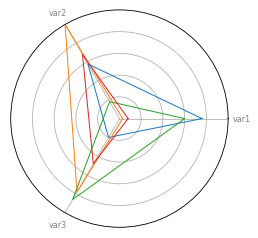

In [3]:
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 50, 9, 34],
'var3': [10, 39, 43, 24],
})
kiviat_diagram(df)

## Preprocessing

### Merging CO2 measurements, temperature and humidity in a single dataframe.

In [4]:
# Load the data
CO2_measurement = pd.read_csv('data/CO2_sensor_measurements.csv', sep='\t')
zurich_average_wind = pd.read_csv('data/zurich_average_wind.csv', sep='\t')
zurich_temp_humidity= pd.read_csv('data/temperature_humidity.csv', sep='\t')
sensors_metadata = pd.read_csv('data/sensors_metadata.csv', sep='\t') 

# Some values are missing, that is why we will interpolate them by taking the average over an interval of 30min.
# We will also aggregate all the information of CO2 measurements, temperature and humidity into one single 
# dataframe for more practicality.

# interpolate CO2_measurement
CO2_measurement = CO2_measurement.interpolate().set_index('timestamp')
CO2_measurement.index = pd.to_datetime(CO2_measurement.index)
grouper = CO2_measurement.groupby([pd.Grouper(freq='30Min'), 'LocationName', 'SensorUnit_ID'])
grouper = grouper.mean()


# interpolate temperature and humidity
zurich_temp_humidity = zurich_temp_humidity.interpolate().set_index('Timestamp')
zurich_temp_humidity.index.names = ['timestamp']
zurich_temp_humidity.index = pd.to_datetime(zurich_temp_humidity.index)
zurich_temp_humidity = zurich_temp_humidity.resample('30Min').mean()

# merge the two dataframes
grouper = grouper.reset_index()
mth = pd.DataFrame()
for e in tqdm(zurich_temp_humidity.columns[::2]):
    id_ = int(e.split('.')[0])
    df = zurich_temp_humidity[['{}.temperature'.format(id_), '{}.humidity'.format(id_)]].rename(
        columns={
            '{}.temperature'.format(id_): 'temperature',
            '{}.humidity'.format(id_):'humidity'
        }
    )
    df['SensorUnit_ID'] = id_
    mth = mth.append(grouper.merge(df.reset_index(), on=['timestamp', 'SensorUnit_ID'])) 
mth = mth.set_index('timestamp')

In [5]:
mth.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937


### Applying K-means for the altitude and wind exposure.

For the altitude: K-means will be computed based on two features of the sensor. Its altitude and its median of the CO2 measurements for the entire month.

In [6]:
# take the median of the CO2_measurements
CO2_measurements = mth[['LocationName', 'CO2']].groupby([pd.Grouper(freq='1M'), 'LocationName'])\
                    .median().reset_index().drop('timestamp', 1).set_index('LocationName')

# select only altitude from the metadata
altitude = sensors_metadata[['LocationName', 'altitude']].set_index('LocationName')

# join both features in a single dataframe
ma = CO2_measurements.join(altitude)
ma.rename(columns={'CO2': 'median CO2'}, inplace=True)
ma.head()

,median CO2,altitude
LocationName,,
AJGR,334.785793,627.8
BSCR,475.316233,462.3
BUDF,422.793126,490.2
KBRL,410.100150,510.5
KTGM,444.395518,530.3


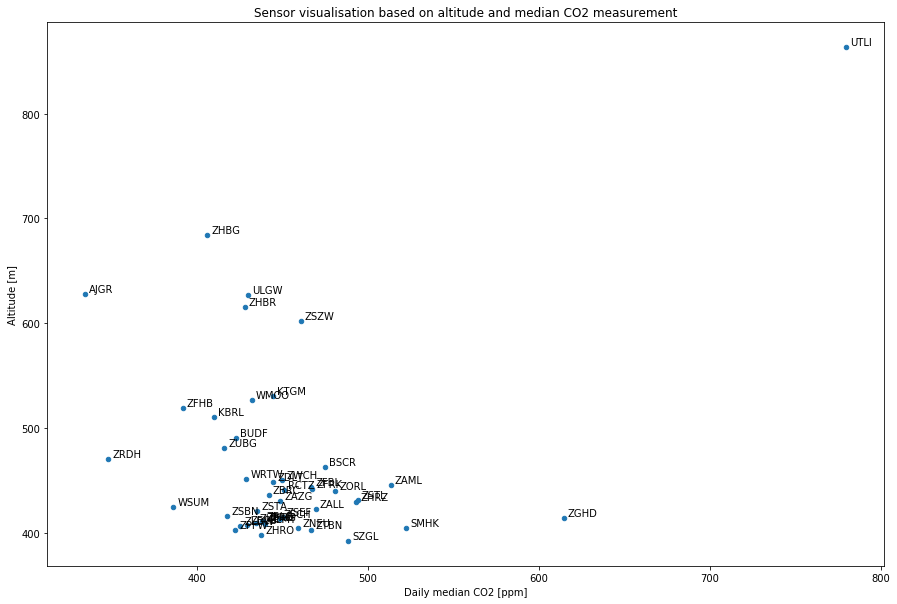

In [7]:
ax = ma.plot(x='median CO2', y='altitude', kind='scatter', figsize=(15, 10))

for k, v in ma.iterrows():
    ax.annotate(k, v, xytext=(4,2), textcoords='offset points', fontsize=10)

plt.title('Sensor visualisation based on altitude and median CO2 measurement')
plt.xlabel('Daily median CO2 [ppm]')
plt.ylabel('Altitude [m]')
plt.show()

#### Determine the correct value of k

In [8]:
def plot_elbow_method(ma, search_space=range(2,11)):
   
    X = ma.values
    kmeans = [KMeans(i) for i in search_space]
    scores = [kmeans[i].fit(X).inertia_ for i in range(len(kmeans))]

    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    ax.plot(search_space, scores)
    plt.title('Elbow method for optimal K')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.yticks([])
    plt.grid()
    plt.show()

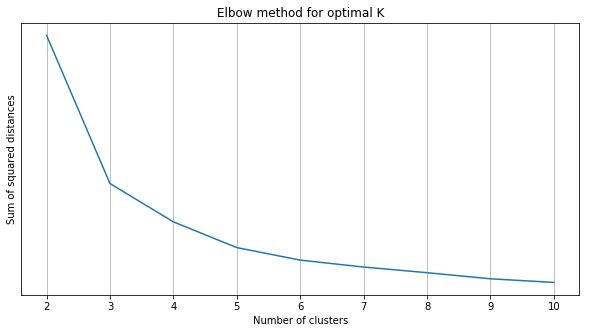

In [9]:
plot_elbow_method(ma[['median CO2', 'altitude']])

In [10]:
"""X = ma.values
range_k = range(2,11)
for k in range_k:
    cluster = KMeans(n_clusters=k)
    cluster_labels = cluster.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('For K={}, the average silhouette score is {:1.5f}.'.format(k, silhouette_avg))"""

"X = ma.values\nrange_k = range(2,11)\nfor k in range_k:\n    cluster = KMeans(n_clusters=k)\n    cluster_labels = cluster.fit_predict(X)\n    silhouette_avg = silhouette_score(X, cluster_labels)\n    print('For K={}, the average silhouette score is {:1.5f}.'.format(k, silhouette_avg))"

In [11]:
ma['altitude_cluster'] = KMeans(K_cluster_altitude).fit(ma[['median CO2', 'altitude']]).labels_
ma.head()

,median CO2,altitude,altitude_cluster
LocationName,,,
AJGR,334.785793,627.8,7
BSCR,475.316233,462.3,1
BUDF,422.793126,490.2,3
KBRL,410.100150,510.5,3
KTGM,444.395518,530.3,3


In [12]:
# merge the in to current dataframe
mth = mth.reset_index().merge(ma.reset_index(), on='LocationName').set_index('timestamp')
mth.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,median CO2,altitude,altitude_cluster
timestamp,,,,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806,614.578185,413.5,4
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097,614.578185,413.5,4
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761,614.578185,413.5,4
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734,614.578185,413.5,4
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937,614.578185,413.5,4


For the wind exposure: we will perform a Principle Component Analysis (PCA) to reduce the dimension to 2 (instead of 48) for a single and perform a daily clustering based on these PCA coefficients.

In [13]:
# load the dataframe
ZU_aw = zurich_average_wind.copy()
ZU_aw.set_index('timestamp', inplace=True)
ZU_aw.index = pd.to_datetime(ZU_aw.index)
ZU_aw.head()

# reorganize structure to perform dimension reduction
daily_sample = pd.DataFrame(columns=list(range(48)))
for index, row in ZU_aw.groupby(ZU_aw.index.day):
    day = row.index[0].date()
    daily_sample.loc[day] = row.values.T[0]

# apply PCA decomposition
pca = decomposition.PCA(n_components=2)
pca_components = pd.DataFrame(columns=['component_1', 'component_2'], index=daily_sample.index)
components_values = pca.fit_transform(daily_sample.values)
pca_components.loc[:] = components_values
pca_components.index.names = ['timestamp']
pca_components.head()

,component_1,component_2
timestamp,,
2017-10-01,-4.106523,-1.663550
2017-10-02,-0.869377,4.207631
2017-10-03,8.023951,-8.309913
2017-10-04,-3.281485,-0.074907
2017-10-05,8.288445,11.560985


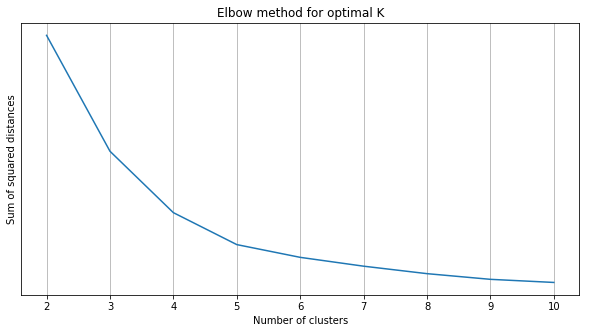

In [14]:
plot_elbow_method(pca_components[['component_1', 'component_2']])

In [15]:
pca_components['wind_cluster'] = KMeans(K_cluster_wind).fit(pca_components[['component_1', 'component_2']]).labels_
pca_components.head()

,component_1,component_2,wind_cluster
timestamp,,,
2017-10-01,-4.106523,-1.663550,2
2017-10-02,-0.869377,4.207631,0
2017-10-03,8.023951,-8.309913,3
2017-10-04,-3.281485,-0.074907,0
2017-10-05,8.288445,11.560985,7


## Faulty sensor modeling

Despite a request to the teaching staff for information about how to properly model a faulty sensor, no useful details have been provided to us as they were mainly guided by the domain experts. Thus, the only behaviour from which we can draw inspiration from is that of the sensor `ZSBN`. In addition, we know that the change occurs after October 24th. The figure below shows the results obtained from the past homework.

![caption](figures/faulty_sensor_from_homework.png)

Although this would require further investigation, we choose a simplistic approach: we will model a faulty sensor as one that undergoes a drift (up or down) and a rescale in amplitude. 

### Create faulty sensors

We will generate faulty sensor from three of them: `AJGR`, `BSCR`, `BUDF`. We will also set the date of failure from the 24th of October. The main reason is that we will only lost about 25% of the data and the remaining 75% of the data will be used for training. We think that the percentage of training data plays a big role in the accuracy of the prediction.

In [16]:
def generate_faulty_sensors(df, sensors, failure_date=24):
    for sensor in sensors:
        co2_measurments = df[df['LocationName'] == sensor]['CO2'].copy()
        df.loc[df['LocationName'] == sensor,'groundtruth'] = co2_measurments.copy()
        condition = co2_measurments.index.day >= failure_date
        std = np.std(co2_measurments.values)
        drift = random.randint(30, 60)
        pourcentage = random.uniform(0.2, 0.3)
        co2_measurments.loc[condition] = (co2_measurments.loc[condition] - drift)/std/pourcentage
        df.loc[df['LocationName'] == sensor, 'CO2'] = co2_measurments
        
def plot_faulty_sensor(df, sensor):
    fig, ax = plt.subplots(figsize=(15,5))
    df[df['LocationName'] == sensor][['CO2', 'groundtruth']].plot(ax=ax)
    plt.title('Example of inaccurate measurement generation for {} sensor'.format(sensor))
    plt.xlabel('Date')
    plt.ylabel('CO2 [ppm]')
    plt.legend(['artifical measurement', 'true measurement'])
    plt.show()

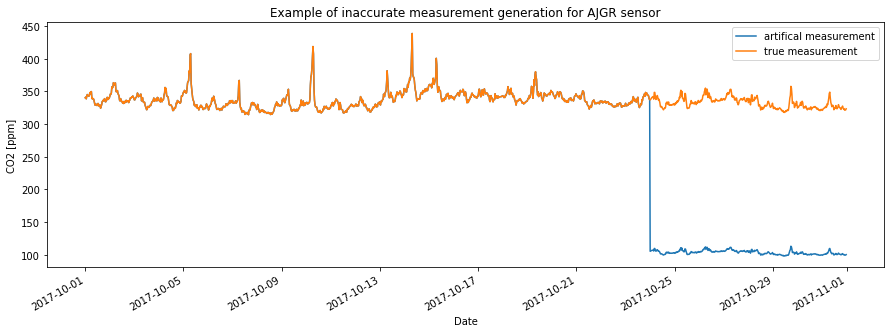

In [17]:
df_mth = mth.copy()
faulty_sensors = ['AJGR', 'BSCR', 'ZSTA', 'ZUE']
generate_faulty_sensors(df_mth, faulty_sensors)
plot_faulty_sensor(df_mth, 'AJGR')

## Performance Evaluation

### 1) Naive Approach
Rely solely on the faulty sensor.

In [18]:
def naive_regression(df, sensors, failure_date=24):
    for sensor in sensors:
        sensor_data = df[df['LocationName'] == sensor]
        condition = sensor_data.index.day >= failure_date
        X_train = sensor_data.loc[~condition][['temperature', 'humidity']].values
        y_train = sensor_data.loc[~condition][['CO2']].values
        X_test = sensor_data.loc[condition][['temperature', 'humidity']].values
        y_test = sensor_data.loc[condition][['CO2']].values
        reg = linear_model.LinearRegression()
        reg.fit(X_train, y_train)
        num_train_samples = X_train.shape[0]
        y_pred = reg.predict(X_test)
        y_pred = np.pad(y_pred, ((num_train_samples, 0), (0,0)), 'constant', constant_values=(np.nan))
        df.loc[df['LocationName'] == sensor, 'naive_prediction'] = y_pred

def plot_prediction(df, sensor, prediction):
    fig, ax = plt.subplots(figsize=(15,5))
    df[df['LocationName'] == sensor][['CO2', 'groundtruth', '{}_prediction'.format(prediction)]].plot(ax=ax)
    plt.title('Prediction using {} approach for {} sensor'.format(prediction, sensor))
    plt.xlabel('Date')
    plt.ylabel('CO2 [ppm]')
    plt.legend(['artifical measurement', 'true measurement', '{} prediction'.format(prediction)])
    plt.show()

def plot_zoomed_prediction(df, sensor, prediction, failure_date=24):
    fig, ax = plt.subplots(figsize=(10,5))
    condition = df.index.day >= failure_date
    df_zoom = df.loc[condition]
    df_zoom[df_zoom['LocationName'] == sensor][['groundtruth', '{}_prediction'.format(prediction)]].plot(ax=ax, color=['#ff7f0e', '#2ca02c'])
    plt.title('Prediction using {} approach for {} sensor (zoomed)'.format(prediction, sensor))
    plt.xlabel('Date')
    plt.ylabel('CO2 [ppm]')
    plt.legend(['true measurement', '{} prediction'.format(prediction)])
    plt.show()

In [19]:
naive_regression(df_mth, faulty_sensors)

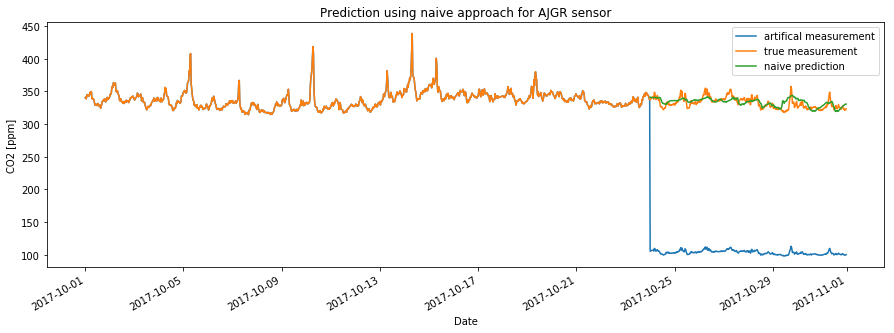

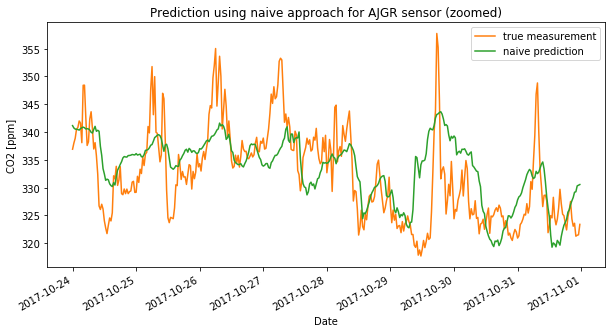

In [20]:
sensor = 'AJGR'
technique = 'naive'
plot_prediction(df_mth, sensor, technique)
plot_zoomed_prediction(df_mth, sensor, technique)

### 2) Add zone and altitude information (za)
We will now make use of the zone of the sensor as well as the clustering on the altitude to train the linear regression.

In [21]:
def za_regression(df, df_altitude, df_metadata, faulty_sensors, failure_date=24):
    for sensor in faulty_sensors:
        
        # aggregate sensors from same zone and cluster altitude
        zone = df_metadata[df_metadata['LocationName'] == sensor]['zone']
        sensors_same_zone = df_metadata[df_metadata['zone'] == zone.values[0]]['LocationName']
        altitude_cluster_id = df_altitude.loc[sensor, 'altitude_cluster']
        sensors_same_altitude_cluster = df_altitude[df_altitude['altitude_cluster'] == altitude_cluster_id].index
        sensors = set(sensors_same_zone).intersection(set(sensors_same_altitude_cluster))
        #print(sensor, sensors)
        
        # prepare masks for train and test
        healthy_mask = df['LocationName'].isin(sensors) & ~df['LocationName'].isin(faulty_sensors)
        nonhealthy_mask = df['LocationName'].isin(sensors) & df['LocationName'].isin(faulty_sensors) & (df.index.day < failure_date)
        
        train_mask = healthy_mask | nonhealthy_mask
        test_mask = (df['LocationName'] == sensor) & (df.index.day >= failure_date)
        
        # create train data
        X_train = df.loc[train_mask][['temperature', 'humidity']].values
        y_train = df.loc[train_mask][['CO2']].values
        
        # create test data
        X_test = df.loc[test_mask][['temperature', 'humidity']].values
        y_test = df.loc[test_mask][['CO2']].values
        
        # fit the model
        reg = linear_model.LinearRegression()
        reg.fit(X_train, y_train)
        
        # predict and pad prediction
        y_pred = reg.predict(X_test)
        num_to_pad = df[df['LocationName'] == sensor].shape[0] - y_pred.shape[0]
        y_pred = np.pad(y_pred, ((num_to_pad, 0), (0,0)), 'constant', constant_values=(np.nan))
        
        #store result
        write_mask = df['LocationName'] == sensor
        df.loc[write_mask, 'za_prediction'] = y_pred

In [22]:
za_regression(df_mth, ma, sensors_metadata, faulty_sensors)

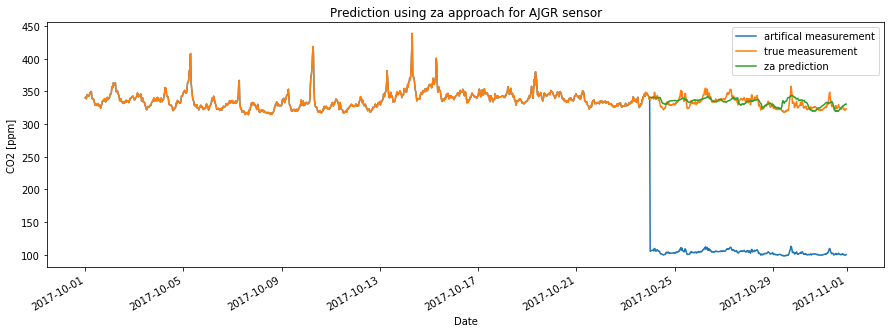

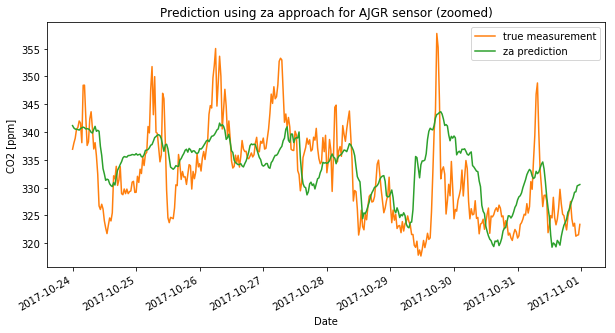

In [23]:
sensor = 'AJGR'
technique = 'za'
plot_prediction(df_mth, sensor, technique)
plot_zoomed_prediction(df_mth, sensor, technique)

In [24]:
def print_MSE(df, sensors, predictions, failure_date=24):
    for sensor in sensors:
        sensor_data = df[df['LocationName'] == sensor]
        condition_sensor = sensor_data.index.day >= failure_date
        sensor_data = sensor_data.loc[condition_sensor]
        print()
        print('{} sensor'.format(sensor))
        print(11*'-')
        for prediction in predictions:
            print('MSE for {} prediction: {:.3f}'.format(
                prediction,
                mean_squared_error(sensor_data['groundtruth'], sensor_data['{}_prediction'.format(prediction)]))
            )

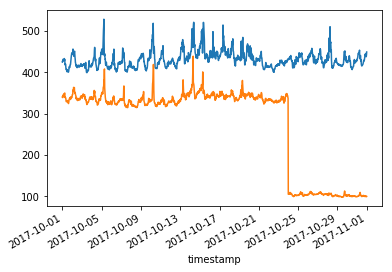

In [25]:
# Il faudra essayer d'expliquer la grosse différence pour AJGR entre naive et za, peut-être avec le wind pattern
# + time of day features cela va disparaître ou s'atténuer. Mais c'est bien car on à trois cas différents.
df_mth[df_mth['LocationName']=='ZHBR']['CO2'].plot()
df_mth[df_mth['LocationName']=='AJGR']['CO2'].plot()

### 3) Add the wind pattern and time feature (wt)
Make use of the different wind patterns to train a new regression model for each of the clusters. In addition, we will add another feature that corresponds to the time of the day (range between 0 and 47) and which represents the intervals of 30min.

In [26]:
# add wind cluster
wind_cluster = pca_components[['wind_cluster']]
wind_cluster.index = pd.to_datetime(wind_cluster.index)
wind_cluster.columns = ['wind_cluster']
wind_cluster = wind_cluster.append(pd.Series(wind_cluster.values[-1], index=wind_cluster.columns, name=(wind_cluster.index[-1] + datetime.timedelta(days=1))))
wind_cluster= wind_cluster.resample('30Min').pad()
df_complete = df_mth.copy()
df_complete = df_complete.join(wind_cluster)
# add time feature
keys = pd.date_range('00:00:00', '23:30:00', freq='30Min').time
values = list(range(48))
dictionary = dict(zip(keys, values))
df_complete['time'] = [dictionary[x] for x in df_complete.index.time]
df_complete.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,median CO2,altitude,altitude_cluster,groundtruth,naive_prediction,za_prediction,wind_cluster,time
timestamp,,,,,,,,,,,,,
2017-10-01,ZGHD,1014,595.004391,11.396667,92.440806,614.578185,413.5,4,NaN,NaN,NaN,2,0
2017-10-01,ZORL,1015,472.855962,10.513333,92.204295,481.065804,439.9,1,NaN,NaN,NaN,2,0
2017-10-01,ZTBN,1016,440.373573,11.040000,92.959605,466.948569,402.9,5,NaN,NaN,NaN,2,0
2017-10-01,ZHRG,1017,425.095878,11.040000,89.914205,439.161697,410.5,8,NaN,NaN,NaN,2,0
2017-10-01,ZSCH,1018,425.687625,11.370000,91.059886,448.509612,413.1,8,NaN,NaN,NaN,2,0


In [27]:
def wt_regression(df, df_altitude, df_metadata, faulty_sensors, failure_date=24):
    for sensor in faulty_sensors:  
        
        # take sensor from same zone and cluster altitude
        sensor_zone = df_metadata[df_metadata['LocationName'] == sensor]['zone']
        zone_sensors = df_metadata[df_metadata['zone'] == sensor_zone.values[0]]['LocationName']
        sensor_altitude_cluster = df_altitude.loc[sensor, 'altitude_cluster']
        altitude_sensors = df_altitude[df_altitude['altitude_cluster'] == sensor_altitude_cluster].index
        sensors = set(zone_sensors).intersection(set(altitude_sensors))

        # create a model for each wind cluster
        df_for_reg_models = df[(df['LocationName'].isin(sensors)) & (~df['LocationName'].isin(faulty_sensors))]
        if df_for_reg_models.shape[0] == 0:
            df_for_reg_models = df[(df['LocationName'].isin(sensors))]# & (df.index.day < failure_date)]
        
        models = []
        cluster_ids = df_for_reg_models['wind_cluster'].unique().tolist()
        cluster_ids.sort()
        for cluster_id in cluster_ids:
            #print(sensor, cluster_id)
            wind_cluster_data = df_for_reg_models[(df_for_reg_models['wind_cluster'] == cluster_id)]

            X = wind_cluster_data[['temperature', 'humidity', 'time']].values
            y = wind_cluster_data[['CO2']].values
            reg = linear_model.LinearRegression()
            reg.fit(X,y)

            models.append(reg)
        #print('--')
        sensor_data = df[df['LocationName'] == sensor]
        condition_sensor = sensor_data.index.day >= failure_date
        sensor_data = sensor_data.loc[condition_sensor]
        for cluster_id in sensor_data['wind_cluster'].unique().tolist():
            #print(sensor, cluster_id)
            mask = (df['LocationName'] == sensor) & (df['wind_cluster'] == cluster_id) & (df.index.day >= failure_date)
            wind_cluster_data = df[mask]
            reg = models[cluster_id]

            X = wind_cluster_data[['temperature', 'humidity', 'time']].values
            y_pred = reg.predict(X)
            df.loc[mask, 'wt_prediction'] = y_pred

In [28]:
wt_regression(df_complete, ma, sensors_metadata, faulty_sensors)

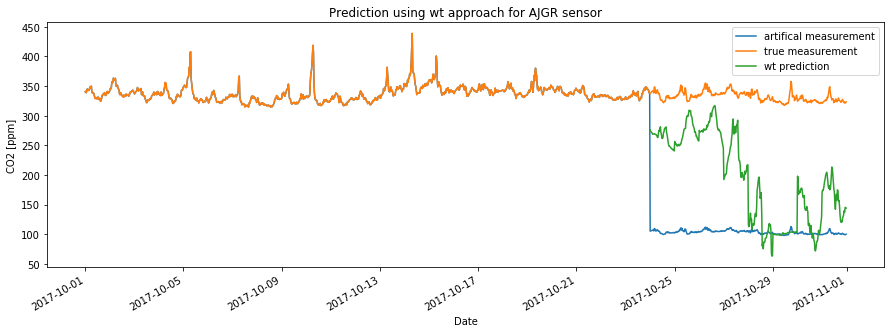

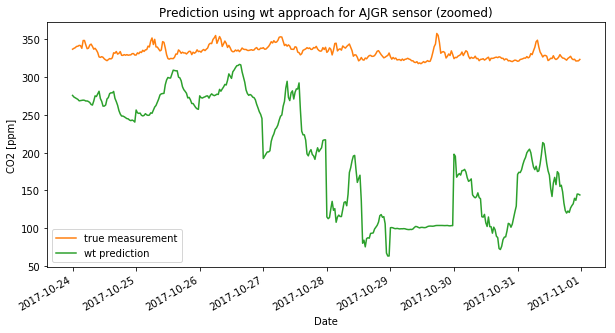

In [29]:
sensor = 'AJGR'
technique = 'wt'
plot_prediction(df_complete, sensor, technique)
plot_zoomed_prediction(df_complete, sensor, technique)

### 4) Brute force

Take everything into consideration without defining any particular cluster for wind or altitude.

In [30]:
# add wind speed value to complete df
df_complete['wind_speed'] = ZU_aw['wind_speed']
df_complete.columns

Index(['LocationName', 'SensorUnit_ID', 'CO2', 'temperature', 'humidity',
       'median CO2', 'altitude', 'altitude_cluster', 'groundtruth',
       'naive_prediction', 'za_prediction', 'wind_cluster', 'time',
       'wt_prediction', 'wind_speed'],
      dtype='object')

In [31]:
def brute_force(df, faulty_sensors, failure_date=24):
    
    correct_sensors_mask = (~df['LocationName'].isin(faulty_sensors)) | \
                            (df['LocationName'].isin(faulty_sensors) & (df.index.day < 24))
    #print(correct_sensors_mask)
    X = df[correct_sensors_mask][['temperature', 'humidity', 'median CO2', 'altitude', 'wind_speed']].values
    y = df[correct_sensors_mask][[ 'CO2']].values
    
    reg = linear_model.LinearRegression()
    reg.fit(X,y)
    
    for sensor in faulty_sensors:
        mask = (df['LocationName'] == sensor) & (df.index.day >= failure_date)
        X = df[mask][['temperature', 'humidity', 'median CO2', 'altitude', 'wind_speed']].values
        y_pred = reg.predict(X)
        df.loc[mask, 'brute_force_prediction'] = y_pred

In [32]:
brute_force(df_complete, faulty_sensors)

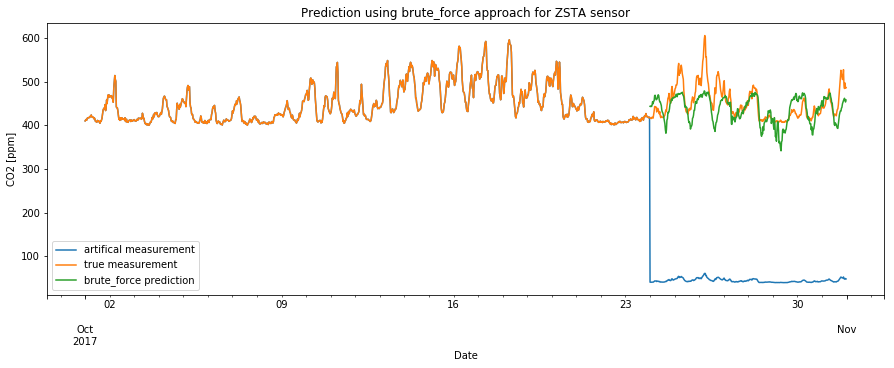

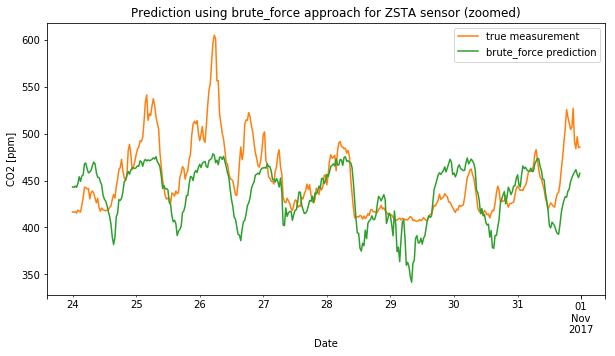

In [33]:
sensor = 'ZSTA'
technique = 'brute_force'
plot_prediction(df_complete, sensor, technique)
plot_zoomed_prediction(df_complete, sensor, technique)

In [34]:
print_MSE(df_complete, faulty_sensors, ['naive', 'za', 'wt', 'brute_force'])


AJGR sensor
-----------
MSE for naive prediction: 44.443
MSE for za prediction: 44.443
MSE for wt prediction: 23651.228
MSE for brute_force prediction: 847.660

BSCR sensor
-----------
MSE for naive prediction: 4995.482
MSE for za prediction: 4677.709
MSE for wt prediction: 4511.087
MSE for brute_force prediction: 4622.873

ZSTA sensor
-----------
MSE for naive prediction: 1501.714
MSE for za prediction: 1222.332
MSE for wt prediction: 863.602
MSE for brute_force prediction: 1193.702

ZUE sensor
-----------
MSE for naive prediction: 1109.108
MSE for za prediction: 1710.846
MSE for wt prediction: 1990.646
MSE for brute_force prediction: 813.353
